# 0.7 Replicating Results with the Updated Task

The final change made to the task shown in [nb-0.1.4](0.1.4-Selectable-Line-Statistics.ipynb) resulted in large changes to results found in previous notebooks. Let's redo the relevant previous analyses so everything is compiled in one place.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [2]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Thu Apr 11 2019 15:36:16 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : 2dce2bc48d77c7dc2cb94fcc05b9fe632f8090a0
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [4]:
# Set the matplotlib mode.
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [5]:
# Standard library imports
import logging
import os
from pathlib import Path

# Third party
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [6]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Metrics visulaization
%aimport leabratf.visualization.metrics
import leabratf.visualization.metrics as plt_metrics
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_DATA_PROC

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [7]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [8]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

### Global Variables

#### Combigen Task Variables

In [9]:
# Number of slots in a training set
SLOTS = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2
# Number of lines per slot 
LINES = 2
# Line frequency statistics
LINE_STATS = [[1,1,1,1,1], [1,1,1,1,1]]

#### Data Parameters

In [10]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN = 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

Here we will introduce new line sampling statistics

In [11]:
# Training Data - Uniform
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, 
                             slots=SLOTS, 
                             size=SIZE, 
                             dims=DIMS, 
                             n_lines=LINES,
                             line_stats=LINE_STATS)
X_TRAIN = cg.inverse_transform(Y_TRAIN)

# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, 
                           slots=SLOTS,  
                           size=SIZE, 
                           dims=DIMS, 
                           n_lines=LINES,
                           line_stats=LINE_STATS)
X_VAL = cg.inverse_transform(Y_VAL)

# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, 
                            slots=SLOTS,  
                            size=SIZE, 
                            dims=DIMS, 
                            n_lines=LINES,
                            line_stats=LINE_STATS)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [12]:
# Learning rate
LR = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = SLOTS * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = SLOTS * SIZE * DIMS

#### Training Parameters

In [13]:
# Number of times to print an update
N_UPDATES = 2
# Which device to train on
TF_DEVICE = '/cpu:0'
# Number of models to train with
N_MODELS = 10
# Recompute the model accuracy after this many epochs
N_EPOCHS_ACC = 25

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. This first section shows the task as always, but then will also go over the previous training curves.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

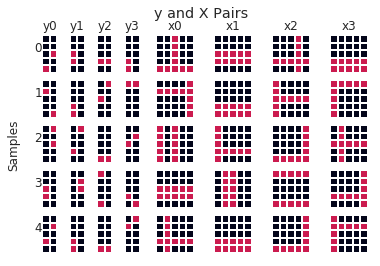

In [14]:
cgh.visualize_combigen(5)
plt.show()

### Adam Optimizer Performance Thus Far

In `nb-0.4.1` we collected data on the models for several different learning rates. Let's read one of them to show the performance when running with the standard dataset.

#### Reading the Data

Let's write a function to read the relevant data we want back into a dictionary, keyed by learning rates.

In [15]:
optimizer_dir = DIR_DATA_PROC / 'different_optimizers'
adam_lr_dict = {}
    
for file in optimizer_dir.iterdir():
    file_name = file.stem
    # Only look at files that containt the fields we are interested in
    if 'adam' not in file_name:
        continue
    # Split the string by underscores
    file_split_name = file_name.split('_')
    # Grab the key from the element thats one before the one we're after
    try:
        lr_key = file_split_name[file_split_name.index('lr')-1]
    # The keyby isnt in the name, which means its a default 
    except ValueError:
        lr_key = 0.01
    # Set the key value
    adam_lr_dict[str(lr_key)] = pd.read_csv(str(file), index_col=0)

#### The Legend

Before plotting everything, let's remind ourselves of the metrics legend. This is a direct copy from `nb-0.3.1`, so skip as needed.

##### Training Set Metrics

Metrics obtained every epoch from from performance on the training set.

- `loss` - Loss for the training set
- `el_acc` - Element-wise accuracy between predictions and labels for the training set
- `ax_acc` - Axis accuracy for each slot in each sample between predictions and labels for the training set. Score per sample goes in eighth steps between 0.0 and 1.0. Every correct axis in every slot contributes 0.125 to the the overall accuracy
- `sl_acc` - Slot accuracy for sample between predictions and labels for the training set. Score per sample goes in quarter steps between 0.0 and 1.0. Any slot that has all elements correct contributes 0.25 to the score
- `sm_acc` - Sample accuracy between predictions and labels for the training set. Score per sample is binary - model must get every element correct to receive 1.0

##### Validation Set Metrics

Metrics obtained every epoch from from performance on the validation set.

- `val_loss` - Loss for the validation set for a particular epoch
- `val_el_acc` - Element-wise accuracy between predictions and labels for the validation set. See above for details
- `val_sl_acc` - Slot accuracy for sample between predictions and labels for the validation set. See above for details
- `val_sm_acc` - Sample accuracy between predictions and labels for the training set. See above for details

#### Adam with LR 0.0033

And now let's plot the one with the 0.0033 LR

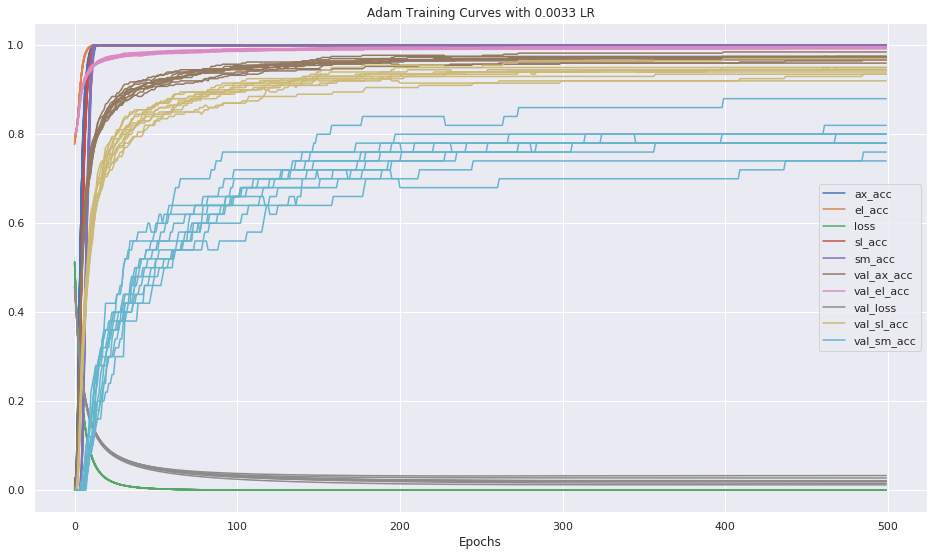

In [16]:
lr = '0.0033'
plt_metrics.plot_df_metrics(adam_lr_dict[lr], 
                            title='Adam Training Curves with {0} LR'.format(lr))
plt.show()

## Setting Up the Graph

This next section will define the computational graph that will be used to generate the metrics down below. It is largely code copied from nb-0.3, so skip around as needed.

In [17]:
# Cleanup any residual nodes
tf.reset_default_graph()

### Make the Different Datasets

Define the various `tf.Dataset`s that will be used including the ones with the different statistics.

In [18]:
def make_tf_datasets(init_ops=None):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    # Training dataset
    dataset_train = tf.data.Dataset.from_tensor_slices(
        (X_TRAIN, Y_TRAIN)).repeat().batch(BATCH_SIZE)
    # Validation dataset
    dataset_val = tf.data.Dataset.from_tensor_slices(
        (X_VAL, Y_VAL)).repeat().batch(N_VAL)
    # Testing dataset
    dataset_test = tf.data.Dataset.from_tensor_slices(
        (X_TEST, Y_TEST)).repeat().batch(N_TEST)
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    train_iter = dataset_train.make_initializable_iterator()
    # Validation iterator
    val_iter = dataset_val.make_initializable_iterator()
    # Testing iterator
    test_iter = dataset_test.make_initializable_iterator()
    # Aggregate the iterators
    iterators = [train_iter, 
                 val_iter, 
                 test_iter]

    # Add the initiatlizations to the init opts
    init_ops = init_ops or []
    init_ops += [train_iter.initializer,
                 val_iter.initializer, 
                 test_iter.initializer]
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, dataset_train.output_types, 
        dataset_train.output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

### TF Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [19]:
# Weights and biases
weights = {
    'h1': tf.get_variable(name='w_h1', shape=[N_INPUTS, N_HIDDEN_1],
                      initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable(name='w_out', shape=[N_HIDDEN_1, N_OUTPUTS],
                      initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'b1': tf.get_variable(name="b_1", shape=[N_HIDDEN_1], 
                      initializer=tf.zeros_initializer()),
    'out': tf.get_variable(name="b_out", shape=[N_OUTPUTS], 
                      initializer=tf.zeros_initializer()),
}

init_ops = []

### Model and Metrics

The architecture is the same as previous notebooks. See `nb-0.3` for more details.

In [20]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, SLOTS, SIZE, DIMS])

In [21]:
with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handle, init_ops = make_tf_datasets(init_ops)

    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))

    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float16))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float16))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float16))

In [22]:
with tf.device(TF_DEVICE):
    # Adam
    train_op_adam = tf.train.AdamOptimizer(alpha_ph).minimize(loss_op)
    # Adadelta 
    train_op_adadelta = tf.train.AdadeltaOptimizer(alpha_ph).minimize(loss_op)
    # RMSProp
    train_op_rmsprop = tf.train.RMSPropOptimizer(alpha_ph).minimize(loss_op)
    # SGD
    train_op_sgd = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)
    
# And now add these to a dictionary
optimizer_dict = {
    'Adam' : train_op_adam,
    'Adadelta' : train_op_adadelta,
    'RMSProp' : train_op_rmsprop,
    'sgd' : train_op_sgd,
}

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [23]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Defining the Default Training Function

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [24]:
def train(sess, lr=LR, epochs=EPOCHS, n_updates=N_UPDATES,
          train_op=optimizer_dict['sgd'], init_ops=None):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'el_acc':[], 'ax_acc':[], 'sl_acc':[], 'sm_acc':[], 
               'val_loss':[], 'val_el_acc':[], 'val_ax_acc':[], 'val_sl_acc':[], 
               'val_sm_acc':[]}
    # Dict for the ongoing accuracy metrics
    sample_accuracy = {}
    # Run the initialization ops
    init_ops = init_ops or []
    init_ops += [tf.global_variables_initializer(), tf.local_variables_initializer()]
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run([i.string_handle() for i in iterators])
    
    for epoch in range(epochs):
        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            _, ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [train_op, loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                feed_dict={handle: training_handle, alpha_ph: lr})
            
        # Get means for the epoch
        epoch_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))

        # Calculate validation accuracy and loss
        val_data = list(sess.run([loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                                 feed_dict={handle: validation_handle}))
#         # Selectively Calculate the accuracy
#         if not epoch % N_EPOCHS_ACC:
#             sample_accuracy[epoch] = sess.run(sample_acc_op, feed_dict={handle: testing_handle})
            
        # Record
        for key, value in zip(metrics.keys(), epoch_data + val_data):
            metrics[key].append(value)

        # Selectively display the epoch number
        if n_updates and (not epoch % (epochs / n_updates) or epoch == epochs - 1):
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss   Sample Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                epoch+1, epochs, epoch_data[0],epoch_data[4], epoch_data[1], 
                val_data[0], val_data[4], val_data[1]))

    # Calculate accuracy for test images
    print("Optimization Finished! Testing Sample Accuracy:", sess.run(
        sample_acc_op, feed_dict={handle: testing_handle}))
    return metrics #, sample_accuracy

## Different Learning Rates

This section will be recreating the main results shown in [nb-0.4](0.4-Exploring-Different-Learning-Rates.ipynb).

### Defining The Experiment Function

In [25]:
def exp_lr(lrs, epochs=EPOCHS):
    sess = new_session()
    metrics_dict = {}
    accuracy_df = pd.DataFrame(columns=lrs)
    exit = False
    for lr in lrs:
        print('Starting training with lr of {0}...'.format(str(lr)))
        metrics, accuracy = [], []
        while len(metrics) < N_MODELS:
            try:
#                 train_metrics, accuracy_dict = train(
                train_metrics = train(
                    sess, 
                    epochs=epochs, 
                    lr=lr, 
                    n_updates=0, 
                    init_ops=init_ops)
                metrics.append(train_metrics)
#                 accuracy_df[lr] = pd.Series(accuracy_dict.values(), index=accuracy_dict.keys())

            except KeyboardInterrupt:
                print('Encountered a KeyboardInterrupt. Starting a IPython Shell.')
                ipy.embed()
                inp = ''
                while inp.lower() not in ['c', 'e', 's']:
                    inp = input("Continue training, exit, or skip current lr? [(C)ontinue/(E)xit/(S)kip]")
                if inp.lower() == 'c':
                    print('Continuing training...')
                    continue
                elif inp.lower() == 's':
                    print('Continuing to next lr...')
                    break
                else:
                    print('Exiting')
                    exit = True
                    break
        if exit: break
        print('Completed training for lr of {0}'.format(str(lr)))
        metrics_dict[lr] = pd.DataFrame(metrics)
        
    return metrics_dict#, accuracy_df

### Getting the Metrics

In [ ]:
%%time
lrs = [0.0333, 0.1]
# lr_metrics, lr_accuracy_df = exp_lr(lrs=lrs, epochs=5*EPOCHS)
lr_metrics = exp_lr(lrs=lrs, epochs=5*EPOCHS)

Starting training with lr of 0.0333...
Optimization Finished! Testing Sample Accuracy: 0.308
Optimization Finished! Testing Sample Accuracy: 0.276


### Saving the Data

In [27]:
def save_data(metrics, n_models=None, lr=LR, n_train=N_TRAIN, n_epochs=None, 
              optimizer='sgd', exp_dir=DIR_DATA_PROC, dryrun=False, train_stats='uni'):
    df_metrics = metrics if isinstance(metrics, pd.DataFrame) else pd.DataFrame(metrics)
    # Grab the exp params
    n_models = n_models or df_metrics.shape[0]
    n_epochs = n_epochs or len(df_metrics.iloc[0,0])
    
    # Create a dict containing different keys and values if they differ
    # from the default exp
    file_name_dict = {}
    # If we used a different number of models
    if n_models != N_MODELS:
        file_name_dict['models'] = str(n_models)
    # If we used a different number of epochs
    if n_epochs != EPOCHS:
        file_name_dict['epochs'] = str(n_epochs)
    # If we used a different number of training samples
    if n_train != N_TRAIN:
        file_name_dict['ntrain'] = str(n_train)
    # If we used a different learning rate
    if float(lr) != LR:
        file_name_dict['lr'] = str(lr)
    # If we used a different optimizer
    if optimizer.lower() != 'sgd':
        file_name_dict['optimizer'] = optimizer.lower()
    # If we used a different training set
    if train_stats.lower() != 'uni':
        file_name_dict['train_stats'] = train_stats.lower()
    
    # Create the filename and path object
    file_name = None
    for key, val in file_name_dict.items():
        if not file_name:
            file_name = '_'.join([str(val), str(key)])
        else:
            file_name = '_'.join([file_name, str(val), str(key)])
    file_name += '.csv'
    exp_file = Path(exp_dir) / file_name
    
    # Save the df if the file does not exist
    if not exp_file.exists():
        if not dryrun:
            df_metrics.to_csv(str(exp_file))
            print("Saved df to '{0}'".format(str(exp_file)))
        else:
            print("Dryrun: (Not) Saved df to '{0}'".format(str(exp_file)))
    else:
        print("File '{0}' present, skipping.".format(str(exp_file)))

In [28]:
lr_dir = DIR_DATA_PROC /  'new_task' /'learning_rates'
assert lr_dir.exists()

In [30]:
for lr_val, lr_data in lr_metrics.items():
    save_data(lr_data, lr=lr_val, exp_dir=lr_dir, dryrun=False)

Saved df to '/home/abdullah_rashed/work/projects/leabra-tf/data/processed/new_task/learning_rates/2500_epochs_0.0333_lr.csv'
Saved df to '/home/abdullah_rashed/work/projects/leabra-tf/data/processed/new_task/learning_rates/2500_epochs_0.1_lr.csv'


### Reading in the Rest of the Data

In [31]:
lr_metrics = {}
for file in lr_dir.iterdir():
    file_name = file.stem
    # Split the string by underscores
    file_split_name = file_name.split('_')
    # Grab the key from the element thats one before the one we're after
    try:
        lr_key = file_split_name[file_split_name.index('lr')-1]
    # The isnt in the name, which means its a default 
    except ValueError:
        lr_key = 0.01
    # Set the key value
    if lr_key not in lr_metrics.keys():
        lr_metrics[str(lr_key)] = pd.read_csv(str(file), index_col=0)

### Plots for SGD with the Different Learning Rates

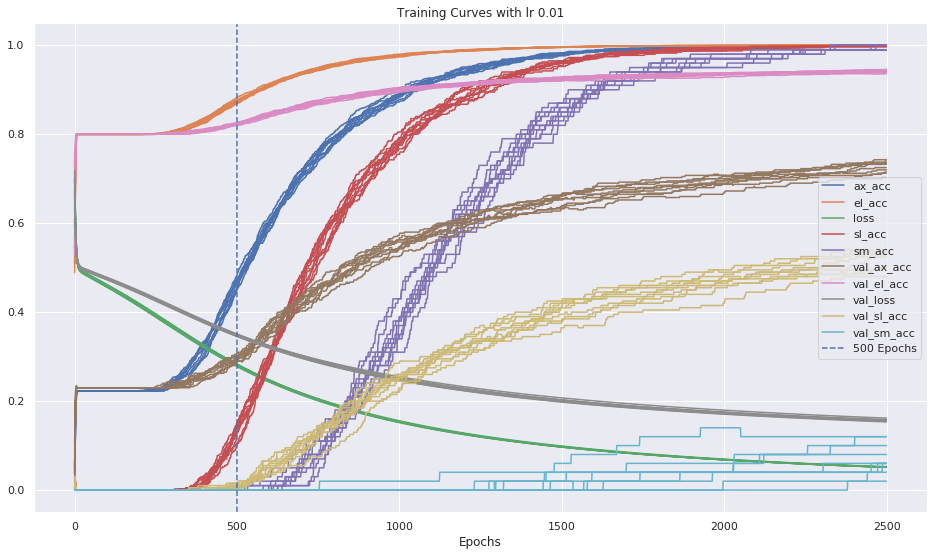

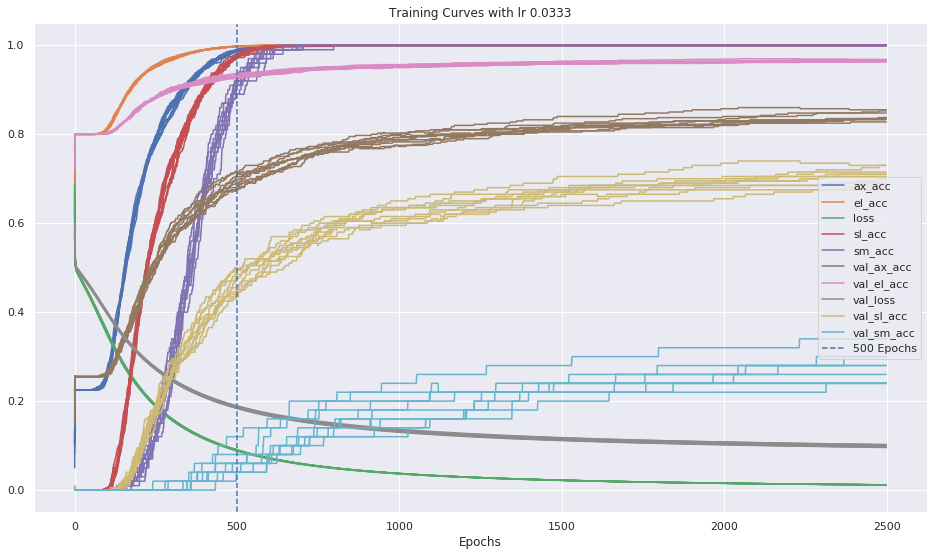

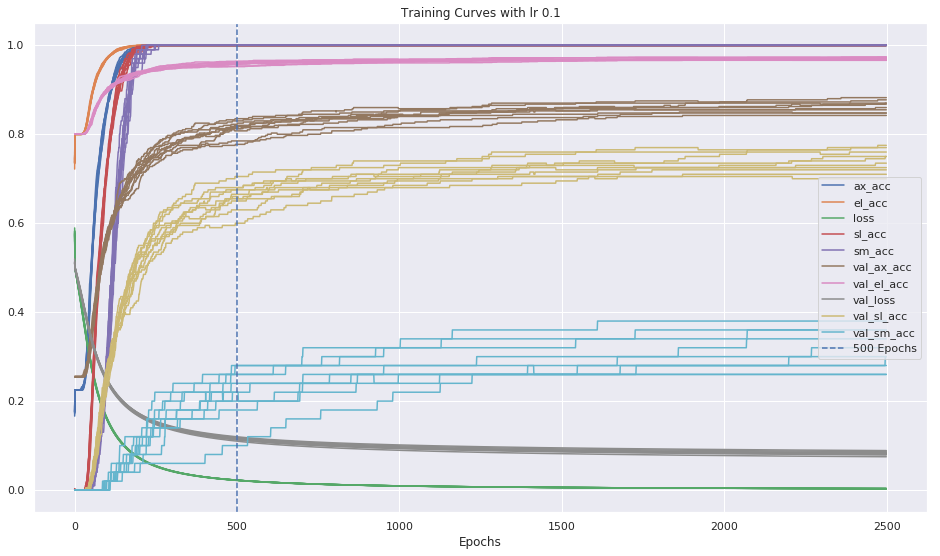

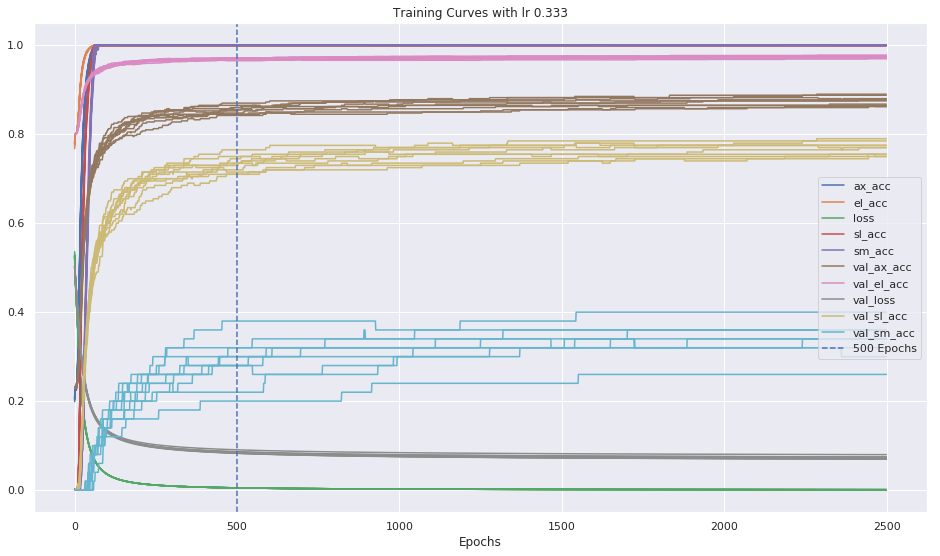

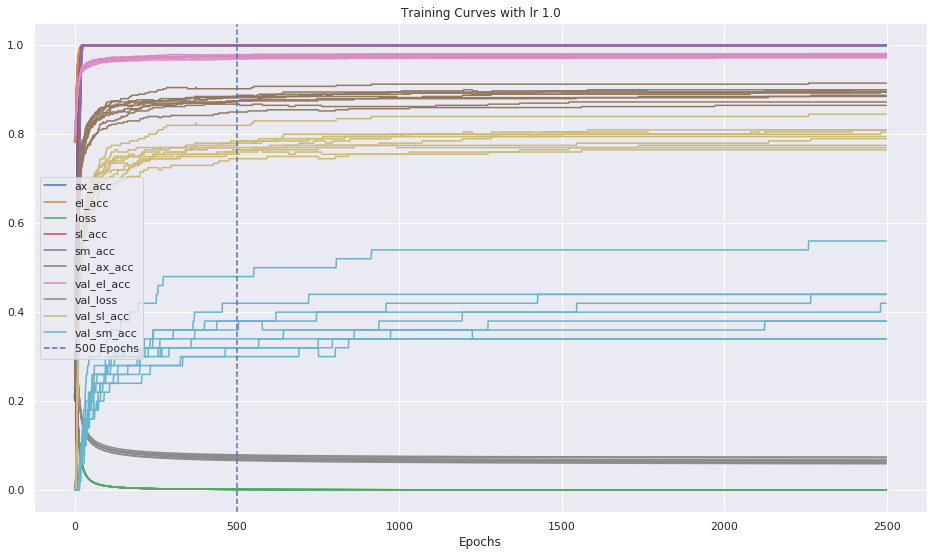

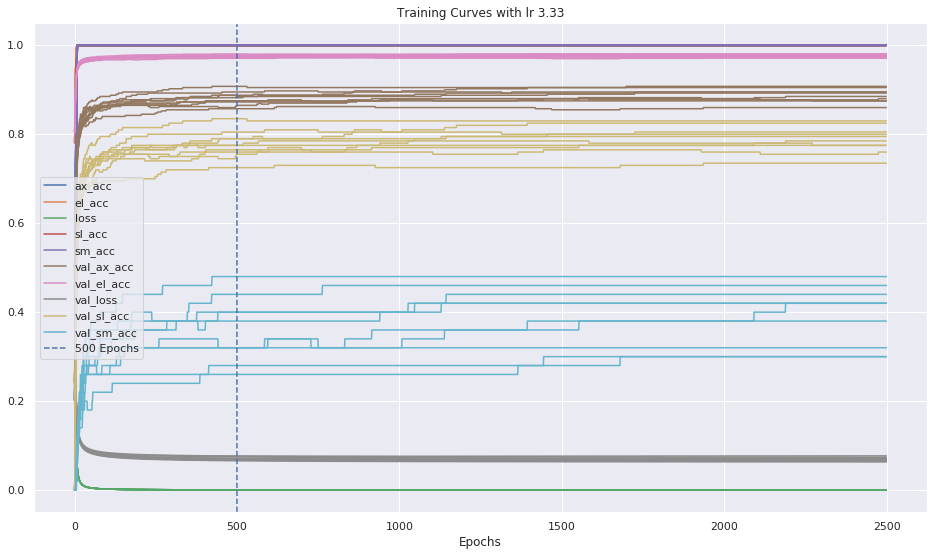

In [32]:
for lr in sorted([float(lr) for lr in lr_metrics.keys()]):
    plt_metrics.plot_df_metrics(lr_metrics[str(lr)], 
                                title='Training Curves with lr {}'.format(str(lr)))
    plt.show()

## Adam Optimizer Learning Rates

This section will recreate the main results shown in [nb-0.5](0.5-Adam-Optimizer-Learning-Rate-Tuning-and-Dropout.ipynb).

### Reading in the Adam LR Data

In [75]:
# The data was saved using an incorrect naming scheme and was put in the 'different_optimizers' dir
adam_lr_dir = DIR_DATA_PROC /  'new_task' / 'different_optimizers'
assert adam_lr_dir.exists()
adam_lr_metrics = {}

In [76]:
for file in adam_lr_dir.iterdir():
    file_name = file.stem
    # Split the string by underscores
    file_split_name = file_name.split('_')
    # Grab the key from the element thats one before the one we're after
    try:
        adam_lr_key = file_split_name[file_split_name.index('lr')-1]
    # The isnt in the name, which means its a default 
    except ValueError:
        adam_lr_key = 0.01
    # Set the key value
    adam_lr_metrics[str(adam_lr_key)] = pd.read_csv(str(file), index_col=0)

### Adam With different Learning Rates

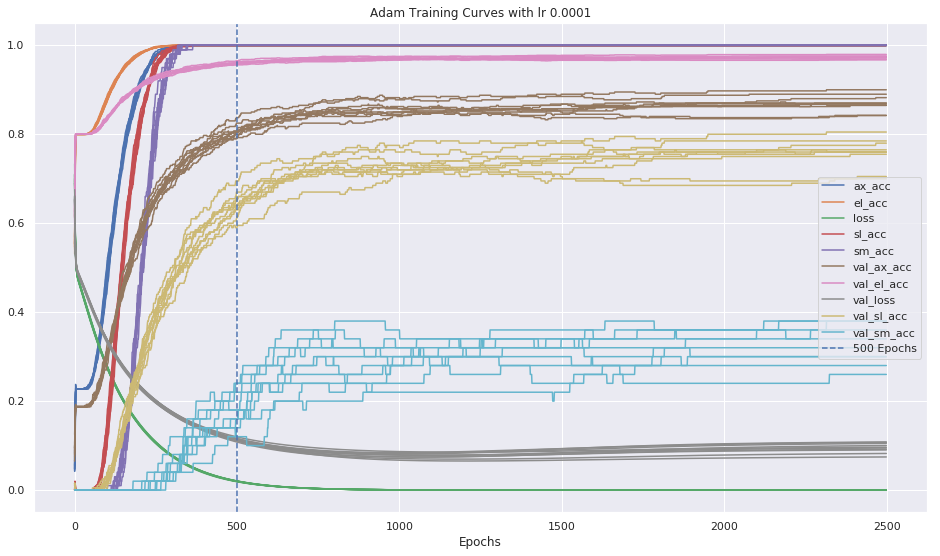

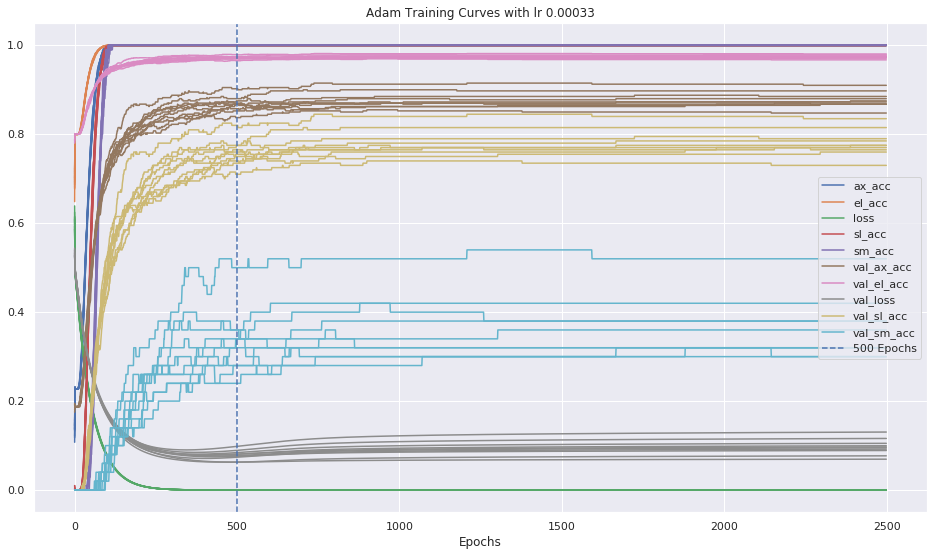

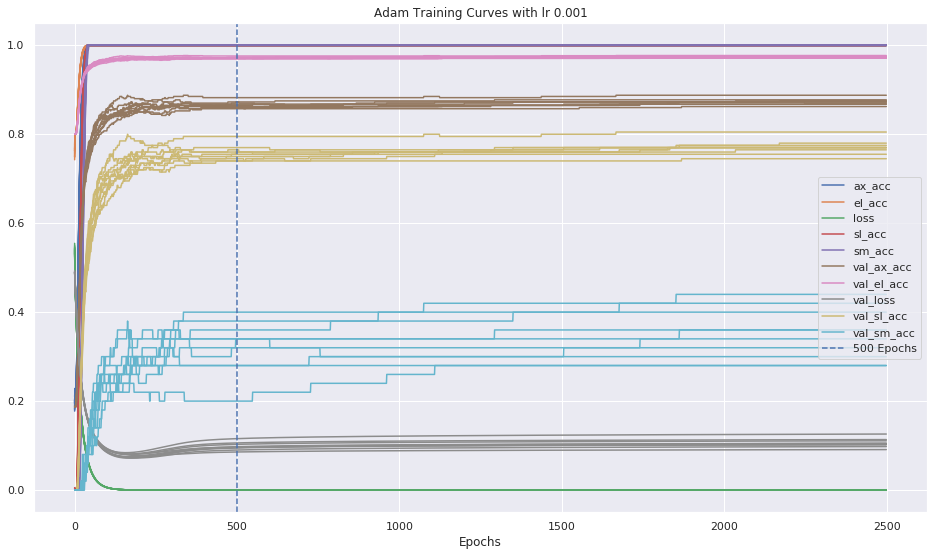

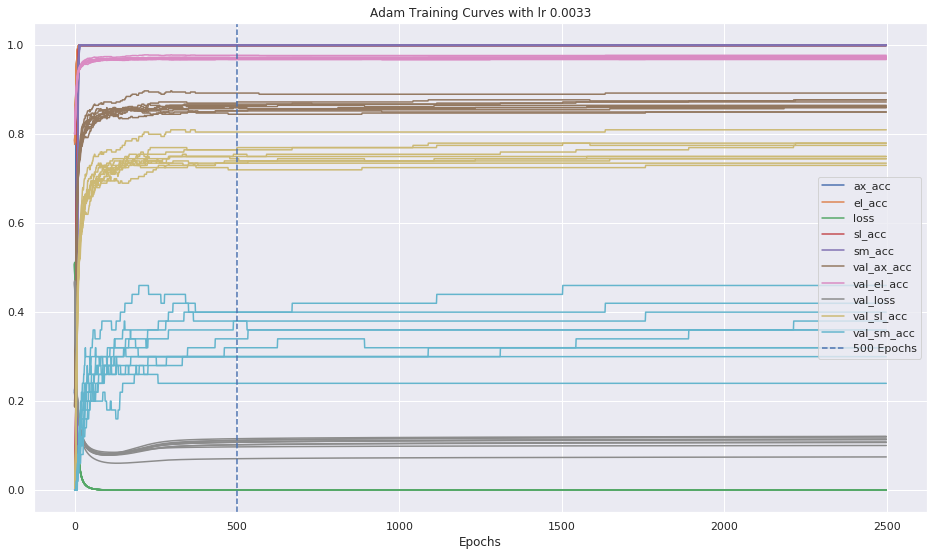

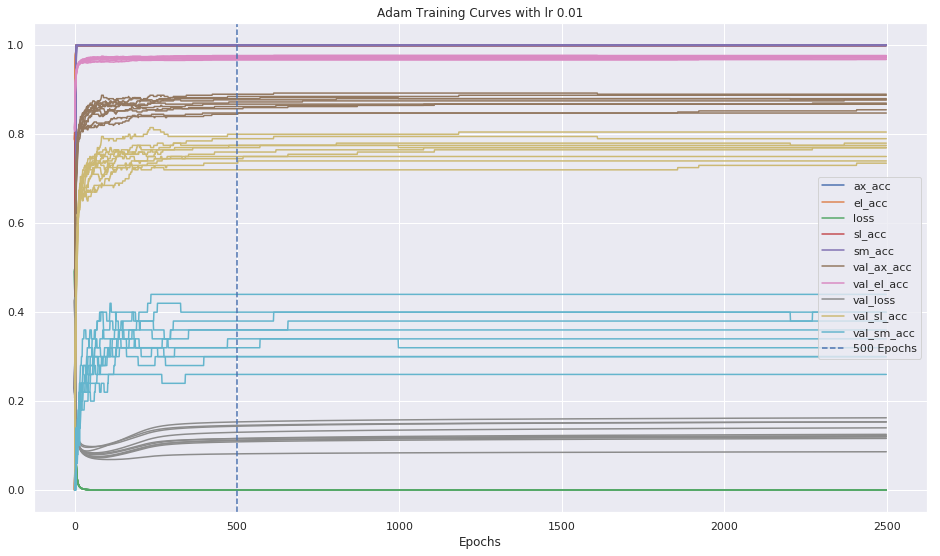

In [78]:
for lr in sorted(adam_lr_metrics.keys()):
    plt_metrics.plot_df_metrics(adam_lr_metrics[str(lr)], 
                                title='Adam Training Curves with lr {}'.format(str(lr)))
    plt.show()